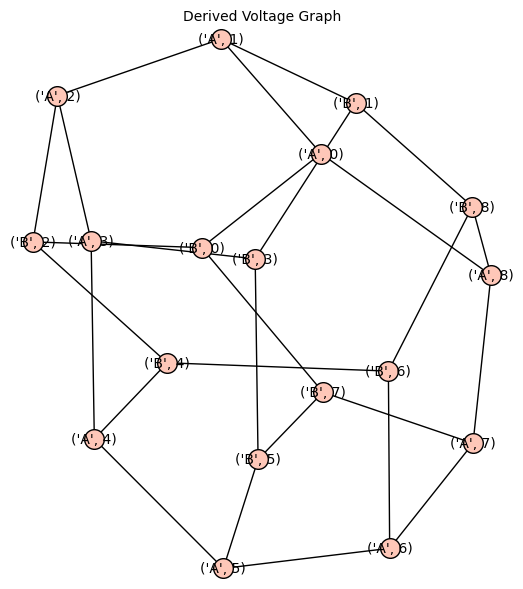

The graph is 3-edge-colorable!


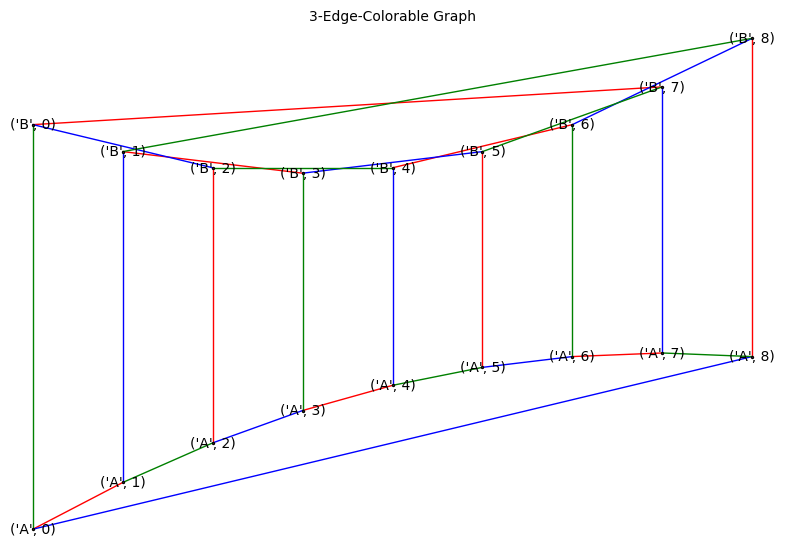


Longest B-only path from B0:
('B', 0) → ('B', 7) → ('B', 5) → ('B', 3) → ('B', 1) → ('B', 8)

Cycle constructed:
('A', 0) → ('B', 0) → ('B', 7) → ('B', 5) → ('B', 3) → ('B', 1) → ('B', 8) → ('A', 8) → ('A', 0)

Edge labels:
(('A', 0), ('B', 0)): 1
(('B', 0), ('B', 7)): 2
(('B', 5), ('B', 7)): 1
(('B', 3), ('B', 5)): 2
(('B', 3), ('B', 1)): 1
(('B', 1), ('B', 8)): 2
(('A', 8), ('B', 8)): 1
(('A', 0), ('A', 8)): 2


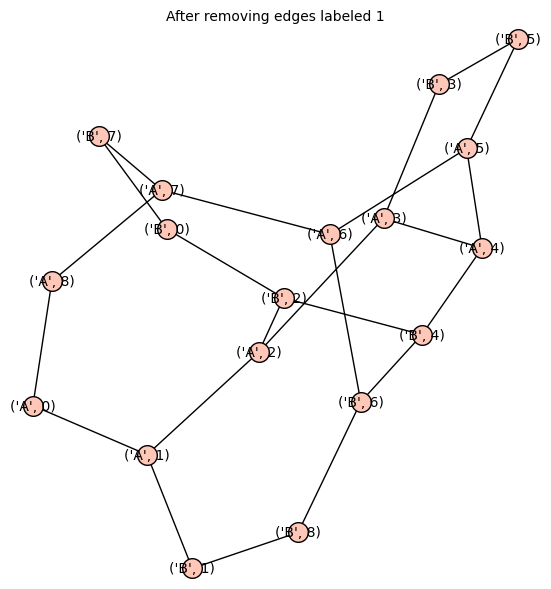

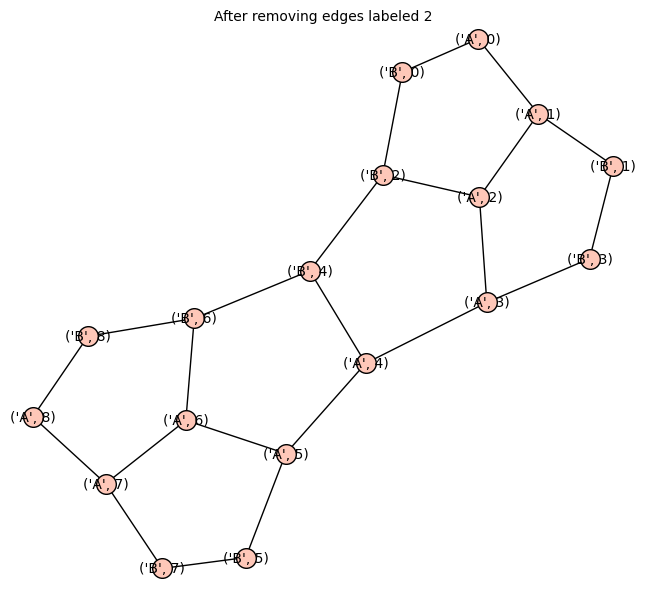

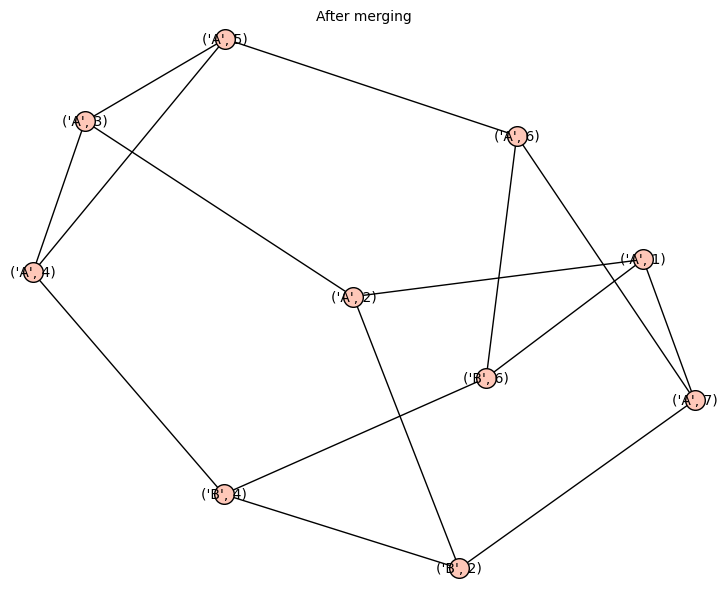

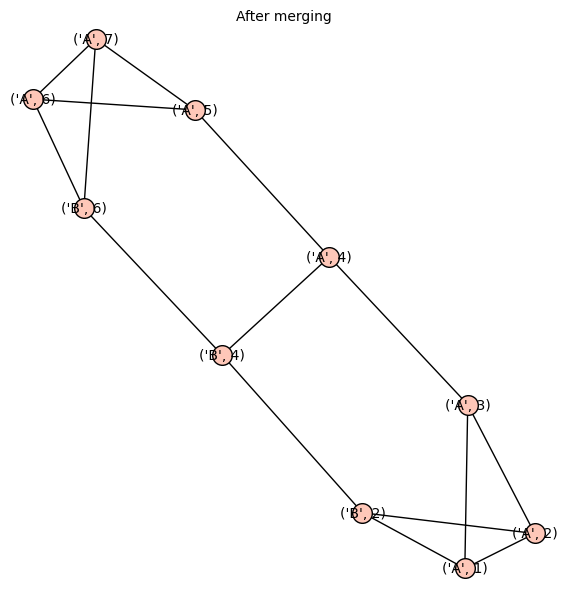

The graph is 3-edge-colorable!


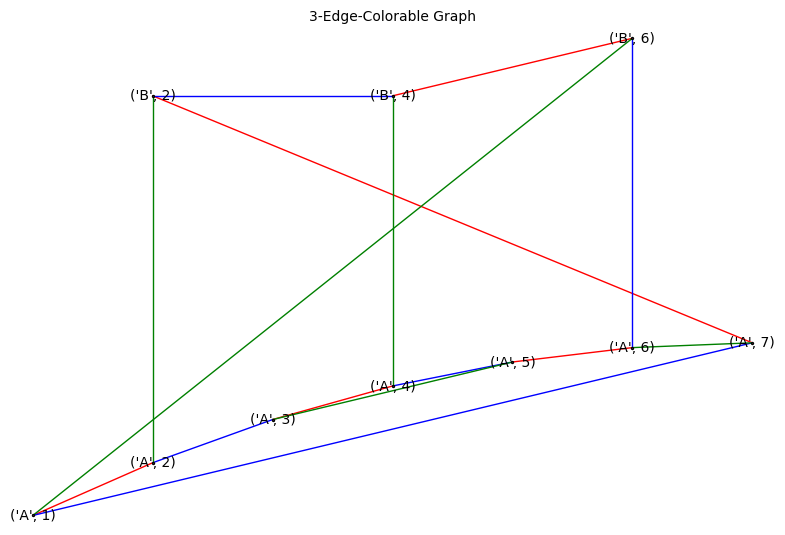

The graph is 3-edge-colorable!


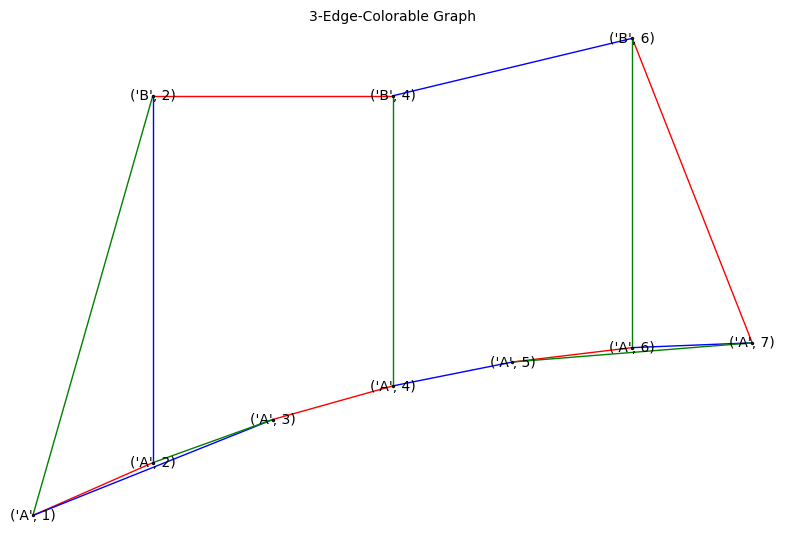

In [4]:
from sage.graphs.graph_coloring import *

def build_voltage_graph(vertices, edges, group_order, phi):
    Gamma = Zmod(group_order)
    derived = Graph(multiedges=False, loops=False)

    lifted_vertices = [(v, g) for v in vertices for g in Gamma]
    derived.add_vertices(lifted_vertices)

    for (u, v) in edges:
        for gamma in Gamma:
            source = (u, gamma)
            target = (v, gamma + phi[(u, v)])
            derived.add_edge(source, target)

    return derived


def longest_B_only_path_to_target(G, group_order):
    Gamma = Zmod(group_order)
    start = ('B', Gamma(0))
    target = ('B', Gamma(group_order - 1))
    
    best_path = []
    
    def dfs(current, visited, path):
        nonlocal best_path
        if current == target:
            if len(path) > len(best_path):
                best_path = path[:]
            return
        for neighbor in G.neighbors(current):
            if neighbor[0] == 'B' and neighbor not in visited:
                visited.add(neighbor)
                path.append(neighbor)
                dfs(neighbor, visited, path)
                path.pop()
                visited.remove(neighbor)
    
    dfs(start, {start}, [start])
    return best_path



def build_cycle_and_label(G, B_path):
    if not B_path:
        print("No valid B-path found.")
        return None, {}

    B0 = B_path[0]
    B_last = B_path[-1]

    A0 = ('A', B0[1])
    A_last = ('A', B_last[1])

    cycle = [A0, B0] + B_path[1:] + [A_last, A0]

    edge_labels = {}
    for i in range(len(cycle)):
        u = cycle[i]
        v = cycle[(i + 1) % len(cycle)]
        if G.has_edge(u, v):
            edge_labels[frozenset((u, v))] = 1 if i % 2 == 0 else 2

    return cycle, edge_labels


def remove_edges_by_label(G, edge_labels, label_to_remove):
    to_delete = [tuple(e) for e, label in edge_labels.items() if label == label_to_remove]
    G.delete_edges(to_delete)
    return to_delete

def remove_edges_by_label_from_original(G, edge_labels, label_to_remove, original_graph):
    G_copy = original_graph.copy()
    
    to_delete = [tuple(e) for e, label in edge_labels.items() if label == label_to_remove]
    G_copy.delete_edges(to_delete)
    return G_copy

def merge_degree_2_vertices(G):
    G_copy = G.copy()

    vertices_to_remove = [v for v in G_copy.vertices() if G_copy.degree(v) == 2]

    for v in vertices_to_remove:
        neighbors = list(G_copy.neighbors(v))
        if len(neighbors) == 2:
            u, w = neighbors
            
            if not G_copy.has_edge(u, w):
                G_copy.add_edge(u, w)

            G_copy.delete_vertex(v)

    return G_copy

def check_and_color_3edge(G):
    G_copy = G.copy()
    edge_coloring_result = edge_coloring(G_copy, solver='GLPK', value_only=False)
    
    if len(edge_coloring_result) <= 3:
        print("The graph is 3-edge-colorable!")

        visible_colors = ['red', 'green', 'blue']
        color_map = {}

        for color_index, color_class in enumerate(edge_coloring_result):
            for (u, v) in color_class:
                color_map[(u, v)] = color_index

        for edge in G_copy.edges():
            G_copy.set_edge_label(edge[0], edge[1], color_map[(edge[0], edge[1])])
            
            
        colors = {0: "red", 1: "blue", 2: "green"}

        set_positions(G_copy)
        return G_copy.plot(edge_colors = G_copy._color_by_label(colors), vertex_size = 2, figsize=(8, 6), title="3-Edge-Colorable Graph")
    else:
        print("The graph is not 3-edge-colorable.")

    return len(edge_coloring_result) <= 3, edge_coloring_result if len(edge_coloring_result) <= 3 else None

def set_positions(G):
    V = G.vertices()
    pos = {}
    for v in V:
        if v[0] == 'A':
            pos[v] = (5 * RDF(v[1]), -0.2 * (RDF(v[1]) - 7) ** 2)
        else:
            pos[v] = (5 * RDF(v[1]), 10 + 0.3 * (RDF(v[1]) - 3) ** 2)
    G.set_pos(pos)


    

# -----------------------------
# Example Setup
# -----------------------------

vertices = ['A', 'B']
edges = [('A', 'B'), ('A', 'A'), ('B', 'B')]
group_order = 9



Gamma = Zmod(group_order)

phi = {
    ('A', 'B'): Gamma(0),
    ('A', 'A'): Gamma(1),
    ('B', 'B'): Gamma(2)
}

D = build_voltage_graph(vertices, edges, group_order, phi)
D.show(figsize=8, title="Derived Voltage Graph")

B0 = ('B', Gamma(0))
B_path = longest_B_only_path_to_target(D, group_order)

#if D.hamiltonian_cycle():
 #   D.hamiltonian_cycle().show()

first = check_and_color_3edge(D)
if first:
    first.show()

print("\nLongest B-only path from B0:")
print(" → ".join(str(v) for v in B_path))

cycle, edge_labels = build_cycle_and_label(D, B_path)

if cycle:
    print("\nCycle constructed:")
    print(" → ".join(str(v) for v in cycle))

    print("\nEdge labels:")
    for edge, label in edge_labels.items():
        print(f"{tuple(edge)}: {label}")

    D1 = remove_edges_by_label_from_original(D, edge_labels, 1, D)
    D1.show(figsize=8, title="After removing edges labeled 1")

    D2 = remove_edges_by_label_from_original(D, edge_labels, 2, D)
    D2.show(figsize=8, title="After removing edges labeled 2")
    
    D1_merged = merge_degree_2_vertices(D1)
    D1_merged.show(figsize=8, title="After merging")
    
    D2_merged = merge_degree_2_vertices(D2)
    D2_merged.show(figsize=8, title="After merging")
    
    colored_plot1 = check_and_color_3edge(D1_merged)
    colored_plot1.show()
    
    colored_plot2 = check_and_color_3edge(D2_merged)
    colored_plot2.show()
    
    
    
else:
    print("No cycle formed.")
